# Hiera encoder + FPN decoder

Want a simple starter encoder + decoder architecture


In [25]:
import torch
import torch.nn.functional as F
from enum import Enum

from torchvision.io import read_image
from torchvision import transforms

import matplotlib.pyplot as plt
import numpy as np

from hiera import hiera_base_224, Hiera

import os
from PIL import Image

device='cuda'
dtype=torch.float32

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# sample tensors used throughout notebook

x = torch.rand(1, 3, 224, 224).to(device)
y = torch.rand(1, 3, 512, 512).to(device)
w = torch.rand((1, 3, 256, 256)).to(device)

## Loading pretrained model from hiera docs

In [3]:
from hiera_utils import pretrained_model

In [4]:
checkpoints = {
    "example_checkpoint": "https://dl.fbaipublicfiles.com/hiera/hiera_base_224.pth"
}

@pretrained_model(checkpoints, default="example_checkpoint")
def create_hiera_model():
    return Hiera(input_size=(256,256), num_classes=10)

In [5]:
model4 = create_hiera_model().to(device)

## Note on unroll func

Find unroll code in hiera_utils

N = 13456 = 464 * 29 (which is patch_size = 16 * 29 = 464) which will be divided by 4
N// 4 = 3364 which sqrt = 58

This doesn't work because we are unrolling the thing several times

Eventaully we do 29 // 2 which loses values for us

Design choice, scale up even further to 512

In [6]:
intermediates = model4(w, return_intermediates=True)

In [7]:
# intermedaites is a list of checkpoints after each downscale by 2 and embed_dim *2
for i in intermediates:
    print(i.shape)

torch.Size([1, 64, 64, 96])
torch.Size([1, 32, 32, 192])
torch.Size([1, 16, 16, 384])
torch.Size([1, 8, 8, 768])


## Prepare sample data

Random images taken from online human segmentation dataset 
Masks arent' very good

https://github.com/VikramShenoy97/Human-Segmentation-Dataset/blob/master/Training_Images/107.jpg

Update: images taken from MSCOCO, download using the api and the pycoco script and then move into images and mask folder

In [263]:
data_dir = 'dataset/val2017'
image_dir = os.path.join(data_dir, 'images')
mask_dir = os.path.join(data_dir, 'masks')
index = np.random.randint(len(image_dir))
image_name = np.sort(os.listdir(image_dir))[index]
img = read_image(os.path.join(image_dir, image_name))
mask = read_image(os.path.join(mask_dir, 'mask_' + image_name))

In [264]:
transform = transforms.Compose([transforms.Resize((256,256)),
                                transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])])
test_transform = transforms.Compose([transforms.Resize((256,256))])

In [265]:
sample = transform(img.to(dtype)) / 255.
print(sample)
mask = test_transform(mask.to(dtype))

tensor([[[4.1573, 4.1526, 4.1487,  ..., 0.0868, 0.1913, 0.6060],
         [4.0924, 4.1621, 4.2187,  ..., 0.3058, 0.9931, 0.4328],
         [4.1604, 4.1838, 4.1915,  ..., 0.3636, 0.5854, 0.3530],
         ...,
         [3.5243, 3.2938, 3.4163,  ..., 3.3730, 3.3854, 3.3253],
         [3.3884, 3.4753, 3.5058,  ..., 3.2367, 3.2796, 3.2796],
         [3.4337, 3.5888, 3.6171,  ..., 3.3439, 3.3593, 3.4068]],

        [[4.2506, 4.2458, 4.2418,  ..., 0.1286, 0.2473, 0.6836],
         [4.1842, 4.2555, 4.3134,  ..., 0.2978, 1.0013, 0.4326],
         [4.2538, 4.2777, 4.2856,  ..., 0.2694, 0.4852, 0.2520],
         ...,
         [3.5335, 3.2978, 3.4230,  ..., 3.4488, 3.4615, 3.4001],
         [3.3945, 3.4834, 3.5146,  ..., 3.3095, 3.3534, 3.3534],
         [3.4408, 3.5994, 3.6283,  ..., 3.4190, 3.4347, 3.4833]],

        [[4.1977, 4.1929, 4.1890,  ..., 0.0723, 0.1317, 0.4663],
         [4.1316, 4.2026, 4.2602,  ..., 0.1701, 0.8675, 0.2368],
         [4.2009, 4.2247, 4.2326,  ..., 0.2301, 0.3793, 0.

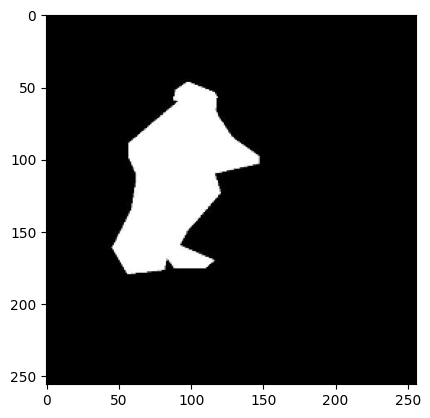

In [266]:
plt.imshow(mask.permute(1, 2, 0), cmap='gray')

In [267]:
imagenet_mean = np.array([0.485, 0.456, 0.406])
imagenet_std = np.array([0.229, 0.224, 0.225])
unnormalize = transforms.Normalize(
        mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
        std=[1/0.229, 1/0.224, 1/0.225]
    )
def imgnet_vis(img, grad=True):
    
    img = unnormalize(img)
    # if uses grad, detach
    if grad:
        image = img.squeeze(0).permute(1, 2, 0).detach()
    else:
        image = img.squeeze(0).permute(1, 2, 0)
    plt.imshow(torch.clip(image, 0, 1))
    plt.axis('off')
    return

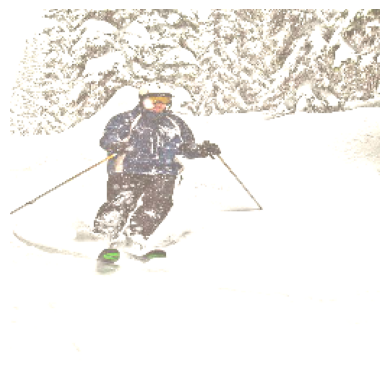

In [268]:
imgnet_vis(sample)

In [191]:
sample = sample.to(device)
mask = mask.to(device)
# add batch
sample = sample.unsqueeze(0)
mask = mask.unsqueeze(0)
sample.shape

torch.Size([1, 3, 256, 256])

In [136]:
intermediates = model4(sample, return_intermediates=True)

In [137]:
for i in intermediates:
    print(i.shape)

torch.Size([1, 64, 64, 96])
torch.Size([1, 32, 32, 192])
torch.Size([1, 16, 16, 384])
torch.Size([1, 8, 8, 768])


## Attach Segmentation head

Simple FPN segmentation head from AOT

https://github.com/yoxu515/aot-benchmark/blob/main/networks/decoders/fpn.py

In [109]:
from fpn_decoder import FPNSegmentationHead

In [110]:
# input dim is last from shortcuts, shortcut dims from intermeidates
head = FPNSegmentationHead(768, 1, decode_intermediate_input=False, shortcut_dims=[96,192,384,768]).to(device)

In [111]:
# expecting b, c, h, w shape
shortcuts = []
for i in intermediates:
    shortcuts.append(i.permute(0, 3, 1, 2))

In [112]:
out = head([shortcuts[-1]], shortcuts)

In [113]:
out.shape

torch.Size([1, 1, 64, 64])

In [114]:
# decode to full size, can also absorb this into the seg head
output_size = [256, 256]
pred_id_logits = torch.nn.functional.interpolate(out,
                               size=output_size,
                               mode="bilinear",
                               align_corners=True)

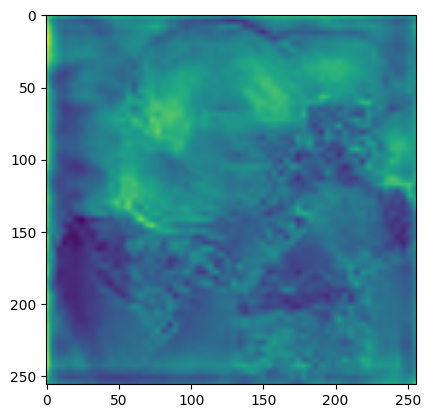

In [116]:
plt.imshow(pred_id_logits.cpu().detach().squeeze(0).permute(1,2,0).numpy())

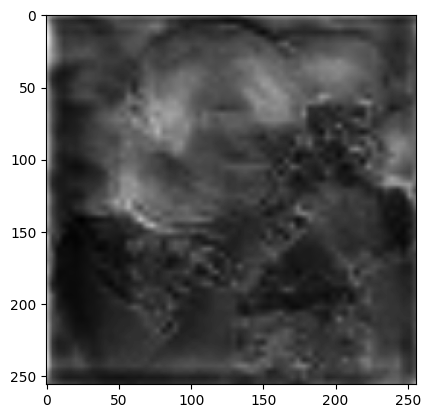

In [117]:
with torch.no_grad():
    pred = torch.sigmoid(pred_id_logits)
    pred_mask = pred.squeeze().cpu().numpy()
    plt.imshow(pred_mask, cmap='gray')
    plt.show()

In [118]:
## Collection of losses

def mean(l, ignore_nan=False, empty=0):
    """
    nanmean compatible with generators.
    """
    l = iter(l)
    if ignore_nan:
        l = ifilterfalse(isnan, l)
    try:
        n = 1
        acc = next(l)
    except StopIteration:
        if empty == 'raise':
            raise ValueError('Empty mean')
        return empty
    for n, v in enumerate(l, 2):
        acc += v
    if n == 1:
        return acc
    return acc / n

def dice_loss(probas, labels, smooth=1):

    C = probas.size(1)
    losses = []
    for c in list(range(C)):
        fg = (labels == c).float()
        if fg.sum() == 0:
            continue
        class_pred = probas[:, c]
        p0 = class_pred
        g0 = fg
        numerator = 2 * torch.sum(p0 * g0) + smooth
        denominator = torch.sum(p0) + torch.sum(g0) + smooth
        losses.append(1 - ((numerator) / (denominator)))
    return 1 - mean(losses)

def flatten_probas(probas, labels, ignore=255):
    """
    Flattens predictions in the batch
    """
    B, C, H, W = probas.size()
    probas = probas.permute(0, 2, 3,
                            1).contiguous().view(-1, C)  # B * H * W, C = P, C
    labels = labels.view(-1)
    if ignore is None:
        return probas, labels
    valid = (labels != ignore)
    vprobas = probas[valid.view(-1, 1).expand(-1, C)].reshape(-1, C)
    # vprobas = probas[torch.nonzero(valid).squeeze()]
    vlabels = labels[valid]
    return vprobas, vlabels

def tversky_loss(probas, labels, alpha=0.5, beta=0.5, epsilon=1e-6):
    '''
    Tversky loss function.
        probas: [P, C] Variable, class probabilities at each prediction (between 0 and 1)
        labels: [P] Tensor, ground truth labels (between 0 and C - 1)

    Same as soft dice loss when alpha=beta=0.5.
    Same as Jaccord loss when alpha=beta=1.0.
    See `Tversky loss function for image segmentation using 3D fully convolutional deep networks`
    https://arxiv.org/pdf/1706.05721.pdf
    '''
    C = probas.size(1)
    losses = []
    for c in list(range(C)):
        fg = (labels == c).float()
        if fg.sum() == 0:
            continue
        class_pred = probas[:, c]
        p0 = class_pred
        p1 = 1 - class_pred
        g0 = fg
        g1 = 1 - fg
        numerator = torch.sum(p0 * g0)
        denominator = numerator + alpha * \
            torch.sum(p0*g1) + beta*torch.sum(p1*g0)
        losses.append(1 - ((numerator) / (denominator + epsilon)))
    return mean(losses)


SMOOTH = 1e-6

def iou_pytorch(outputs: torch.Tensor, labels: torch.Tensor):
    # You can comment out this line if you are passing tensors of equal shape
    # But if you are passing output from UNet or something it will most probably
    # be with the BATCH x 1 x H x W shape
    outputs = outputs.squeeze(1)  # BATCH x 1 x H x W => BATCH x H x W
    
    intersection = (outputs & labels).float().sum((1, 2))  # Will be zero if Truth=0 or Prediction=0
    union = (outputs | labels).float().sum((1, 2))         # Will be zzero if both are 0
    
    iou = (intersection + SMOOTH) / (union + SMOOTH)  # We smooth our devision to avoid 0/0
    
    thresholded = torch.clamp(20 * (iou - 0.5), 0, 10).ceil() / 10  # This is equal to comparing with thresolds
    
    return thresholded  # Or thresholded.mean() if you are interested in average across the batch

def iou_loss(preds, targets, smooth=1e-6):
    """
    Calculate Intersection over Union (IoU) loss

    Arguments:
    preds -- tensor of model predictions (before sigmoid activation function if used with BCEWithLogitsLoss)
    targets -- tensor of target values, same shape as preds
    smooth -- smoothing factor to prevent division by zero

    Returns:
    IoU loss as a single float tensor
    """
    # Apply sigmoid to preds to get the binary mask, if your model doesn't include a final sigmoid activation
    # preds = torch.sigmoid(preds)

    # Calculate intersection and union
    intersection = (preds * targets).sum(dim=(2, 3))  # Sum over height and width dimensions
    total = (preds + targets).sum(dim=(2, 3))
    union = total - intersection

    # Calculate IoU and IoU loss
    iou = (intersection + smooth) / (union + smooth)
    loss = 1 - iou  # Subtracting from 1 to make it a loss (higher is worse)

    # Average over the batch
    return loss.mean()

def jaccord_loss(pred, label, ignore_index=True):
    pred = F.softmax(pred, dim=1)
    label = label.view(1, 1, pred.size()[2], pred.size()[3])
    loss = tversky_loss(*flatten_probas(pred, label, ignore=ignore_index),alpha=1.0,beta=1.0)
    return loss

In [138]:
# loss_fn = dice_loss
loss_fn = iou_loss
# loss_fn = jaccord_loss
# loss_fn = torch.nn.BCEWithLogitsLoss()

## Condense model into single module

In [230]:
from timm.models.vision_transformer_sam import Block

class Model(torch.nn.Module):
    def __init__(self, embed_dim=768, num_heads=12, depth=10):
        super().__init__()
        self.encoder = create_hiera_model()
        for param in self.encoder.parameters():
            param.requires_grad = False
        self.blocks = torch.nn.Sequential(*[
            Block(embed_dim, num_heads) for _ in range(depth)
        ])
        # self.block = Block(embed_dim, num_heads)
        self.decoder = FPNSegmentationHead(embed_dim, 1, decode_intermediate_input=False, shortcut_dims=[96,192,384,768])
        
    def forward(self, x):
        intermediates = self.encoder(x, return_intermediates=True)
        shortcuts = []
        x = intermediates[-1]
        for i in intermediates:
            shortcuts.append(i.permute(0, 3, 1, 2))
        x = self.blocks(x).permute(0, 3, 1, 2)
        x = self.decoder([x], shortcuts)
        return x

In [140]:
m = Model().to(device)
sum(p.numel() for p in m.parameters())

123126155

In [141]:
optim = torch.optim.Adam(m.parameters(), lr=0.001)

In [142]:
# repeat training for number of steps
output_size = [256, 256]

for _ in range(100):
    optim.zero_grad()
    out = m(sample) # output is mask of shape 64x64, so we interpolate it to 256x256
    pred_id_logits = torch.nn.functional.interpolate(out,
                                   size=output_size,
                                   mode="bilinear",
                                   align_corners=True)
    loss = loss_fn(pred_id_logits, mask)
    print(loss.item())
    loss.backward()
    optim.step()

1.5869591236114502
2.5985257625579834
2.2760725021362305
2.223071336746216
2.1414718627929688
2.146496295928955
2.0816330909729004
2.392605781555176
2.109139919281006
2.164243698120117
2.182417392730713
2.1933882236480713
2.1996078491210938
2.2023544311523438
2.2024221420288086
2.200249195098877
2.1962242126464844
2.1906566619873047
2.1837103366851807
2.175499677658081
2.1660518646240234
2.1553728580474854
2.143451690673828
2.1302924156188965
2.1159920692443848
2.101062774658203
2.0865092277526855
2.074397087097168
2.067106008529663
2.0651297569274902
2.0673394203186035
2.0700454711914062
2.067617177963257
2.0607967376708984
2.060969352722168
2.0616862773895264
2.0597848892211914
2.056122303009033
2.0517868995666504
2.0478787422180176
2.0445308685302734
2.041748285293579
2.0394797325134277
2.037649154663086
2.0361742973327637
2.0349843502044678
2.034027099609375
2.033266305923462
2.0326719284057617
2.0322189331054688
2.031869888305664
2.031681537628174
2.03161883354187
2.0316162109375


[8.5374579e-04 8.5635914e-04 8.6460903e-04 ... 9.9999976e-01 9.9999988e-01
 1.0000000e+00]


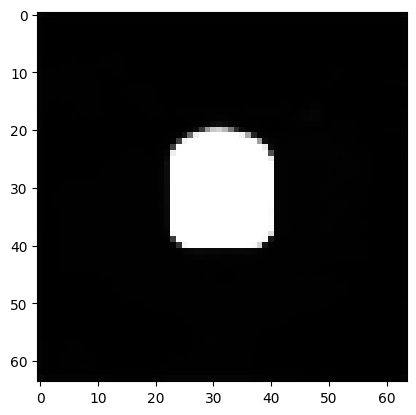

In [143]:
with torch.no_grad():
    m.eval()
    pred = torch.sigmoid(m(sample))
    pred_mask = pred.squeeze().cpu().numpy()
    print(np.unique(pred_mask))
    plt.imshow(pred_mask, cmap='gray')
    plt.show()

## Note: this extreme divergence isn't good, shouldn't be negative either

In [287]:
iou_pytorch(pred_id_logits.to(torch.int), mask.to(torch.int))

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.

## Dataloader



In [231]:
from torch.utils.data import Dataset, DataLoader, Subset
from PIL import Image

class ImageMaskDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        """
        Args:
            image_dir (string): Directory with all the images.
            mask_dir (string): Directory with all the masks.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.image_names = [f for f in os.listdir(image_dir) if os.path.isfile(os.path.join(image_dir, f))]
        self.transform = transform
        self.dtype = torch.float32
        self.resize = transforms.Resize((256,256))
        self.normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

    def __len__(self):
        return len(self.image_names)

    def __getitem__(self, idx):
        img_name = os.path.join(self.image_dir, self.image_names[idx])
        mask_name = os.path.join(self.mask_dir, f"mask_{self.image_names[idx]}")
        image = read_image(img_name) / 255.
        image = image.to(self.dtype)
        mask = read_image(mask_name).to(self.dtype)

        if self.transform:
            image = self.resize(image)
            if image.shape[0] == 1:
                image = torch.cat([image, image, image], dim=0)
            image = self.normalize(image)
            mask = self.resize(mask)

        return image, mask

In [232]:
t = transforms.Compose([transforms.Resize((256,256)),
                        transforms.ToTensor()])

In [233]:
batch_size = 4
root_dir = '/home/hice1/tpeat3/scratch/seg-replace/seg/dataset/val2017'
image_dir = os.path.join(root_dir, 'images')
mask_dir = os.path.join(root_dir, 'masks')

# reuse tranforms we used earlier
dataset = ImageMaskDataset(image_dir, mask_dir, transform=transform)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [239]:
## soft jaccard score

import torch.nn.functional as F

def soft_jaccard_score(
    output: torch.Tensor,
    target: torch.Tensor,
    smooth: float = 0.0,
    eps: float = 1e-7,
    dims=None,
) -> torch.Tensor:
    assert output.size() == target.size()
    if dims is not None:
        intersection = torch.sum(output * target, dim=dims)
        cardinality = torch.sum(output + target, dim=dims)
    else:
        intersection = torch.sum(output * target)
        cardinality = torch.sum(output + target)

    union = cardinality - intersection
    jaccard_score = (intersection + smooth) / (union + smooth).clamp_min(eps)
    return jaccard_score


def tristan_iou(pred, target):
    
    pred = F.logsigmoid(pred).exp()
    
    dims = (0, 2)
    scores = soft_jaccard_score(
            pred,
            target.type(pred.dtype),
            dims=dims,
        )
    
    
    loss = 1.0 - scores
    
    mask = target.sum(dims) > 0
    loss *= mask.float()


    return loss.mean()

def _threshold(x, threshold=None):
    if threshold is not None:
        return (x > threshold).type(x.dtype)
    else:
        return x
    
def _take_channels(*xs, ignore_channels=None):
    if ignore_channels is None:
        return xs
    else:
        channels = [channel for channel in range(xs[0].shape[1]) if channel not in ignore_channels]
        xs = [torch.index_select(x, dim=1, index=torch.tensor(channels).to(x.device)) for x in xs]
        return xs

def f_score(pr, gt, beta=1, eps=1e-7, threshold=None, ignore_channels=None):
    """Calculate F-score between ground truth and prediction
    Args:
        pr (torch.Tensor): predicted tensor
        gt (torch.Tensor):  ground truth tensor
        beta (float): positive constant
        eps (float): epsilon to avoid zero division
        threshold: threshold for outputs binarization
    Returns:
        float: F score
    """

    pr = _threshold(pr, threshold=threshold)
    pr, gt = _take_channels(pr, gt, ignore_channels=ignore_channels)

    tp = torch.sum(gt * pr)
    fp = torch.sum(pr) - tp
    fn = torch.sum(gt) - tp

    score = ((1 + beta**2) * tp + eps) / ((1 + beta**2) * tp + beta**2 * fn + fp + eps)

    return score

def tristan_dice(pred, target):
    return 1 - f_score(pred, target)

In [247]:
indices = np.random.choice(1700, 10, replace=False)
subset = Subset(dataset, indices)

# Create a DataLoader for the subset
subset_dataloader = DataLoader(subset, batch_size=1, shuffle=False)  # Batch size is 1 for individual processing

In [260]:
from tqdm import tqdm

model = Model().to(device)
model.train()
optim = torch.optim.RAdam(model.parameters(), lr=0.001)
# bce_loss = torch.nn.BCEWithLogitsLoss()
ce_loss = torch.nn.CrossEntropyLoss()

losses = []
num_epochs = 40
for epoch in range(num_epochs):
    pbar = tqdm(enumerate(subset_dataloader), total=len(subset_dataloader), desc=f'Epoch {epoch+1}/{num_epochs}')
    total_loss = 0
    count = 0
    
    for i, (sample, mask) in pbar:
        sample, mask = sample.to(device), mask.to(device)
        optim.zero_grad()
        out = model(sample)
        pred_id_logits = torch.nn.functional.interpolate(out,
                                       size=output_size,
                                       mode="bilinear",
                                       align_corners=True)

        loss = tristan_iou(pred_id_logits, mask) + tristan_dice(pred_id_logits, mask)
        # d_loss = dice_loss(pred_id_logits, mask)
#         c_loss = ce_loss(pred_id_logits, mask)
#         loss = i_loss + c_loss
        total_loss += loss.item()
        count += 1
        loss.backward()
        optim.step()

        pbar.set_description(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item():.4f}")
        
    losses.append(total_loss / count)

Epoch 40/40, Loss: -111.8327: 100%|██████████| 10/10 [00:00<00:00, 14.53it/s]


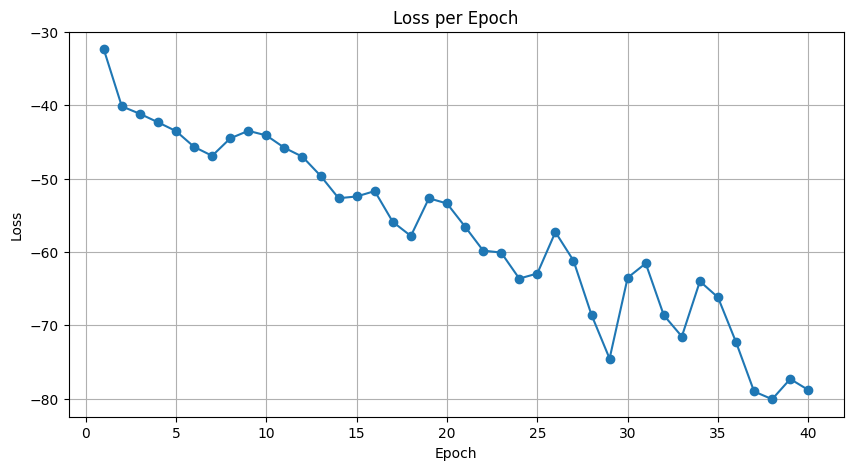

In [261]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs+1), losses, marker='o')
plt.title('Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

torch.Size([1, 3, 256, 256])


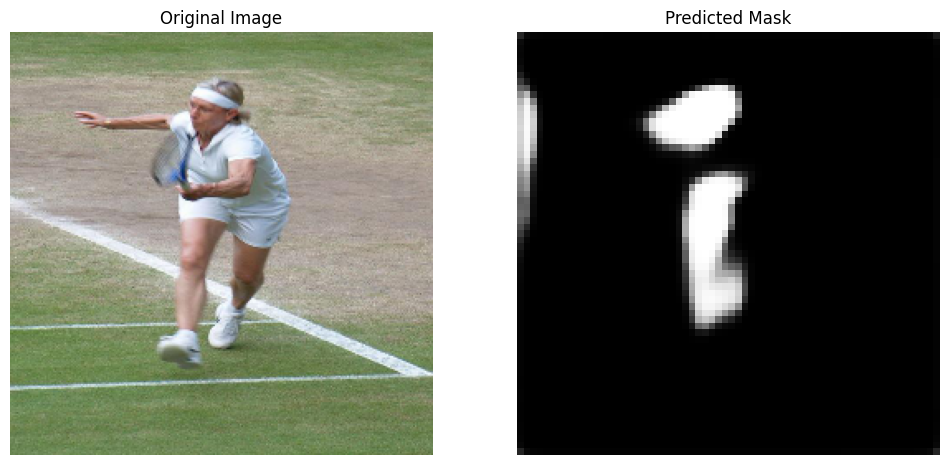

torch.Size([1, 3, 256, 256])


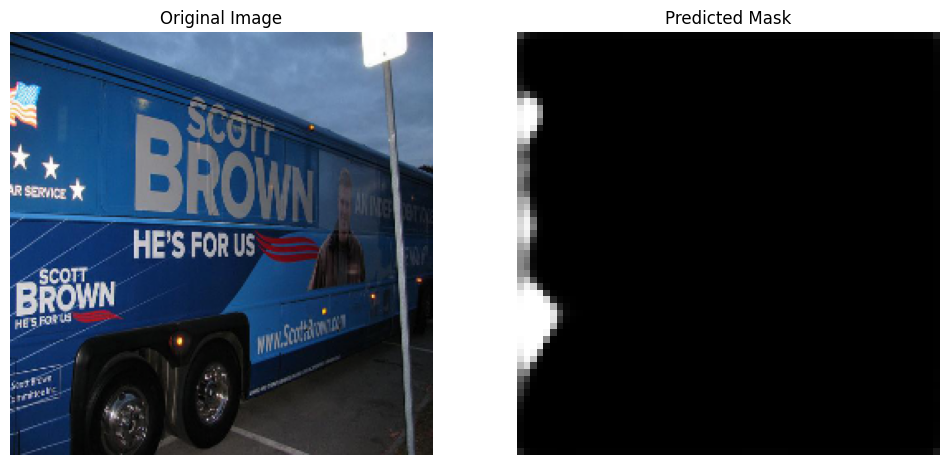

torch.Size([1, 3, 256, 256])


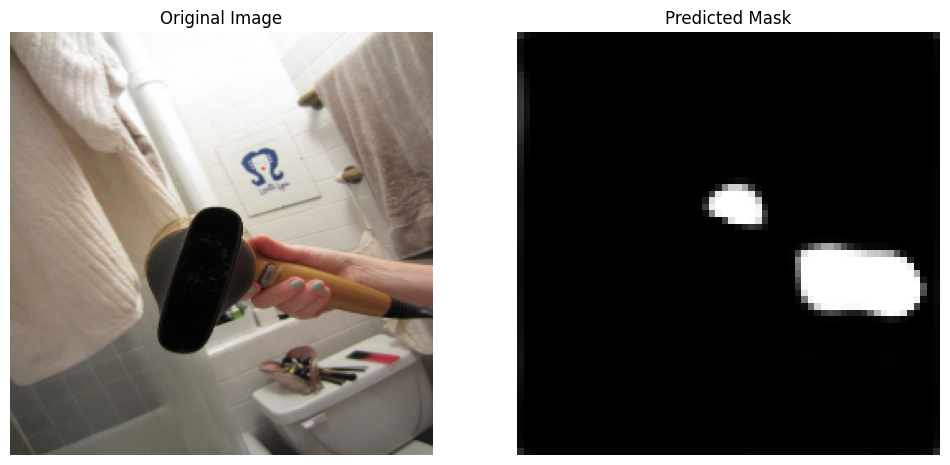

torch.Size([1, 3, 256, 256])


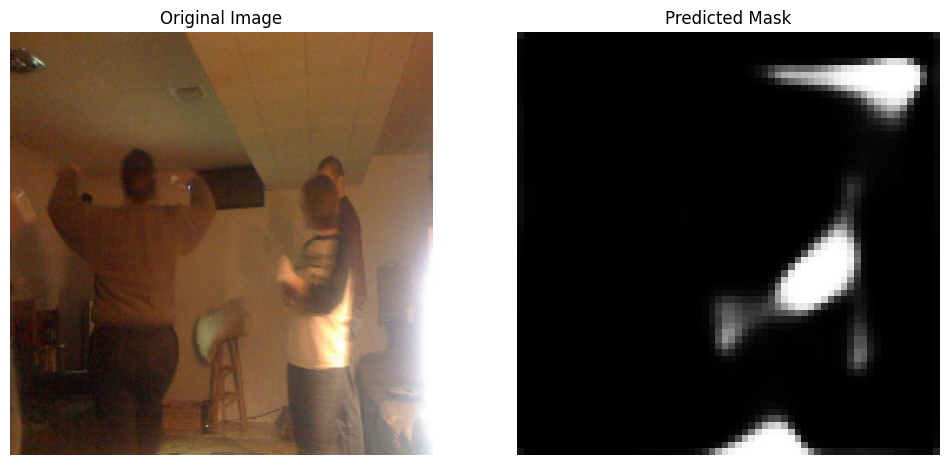

torch.Size([1, 3, 256, 256])


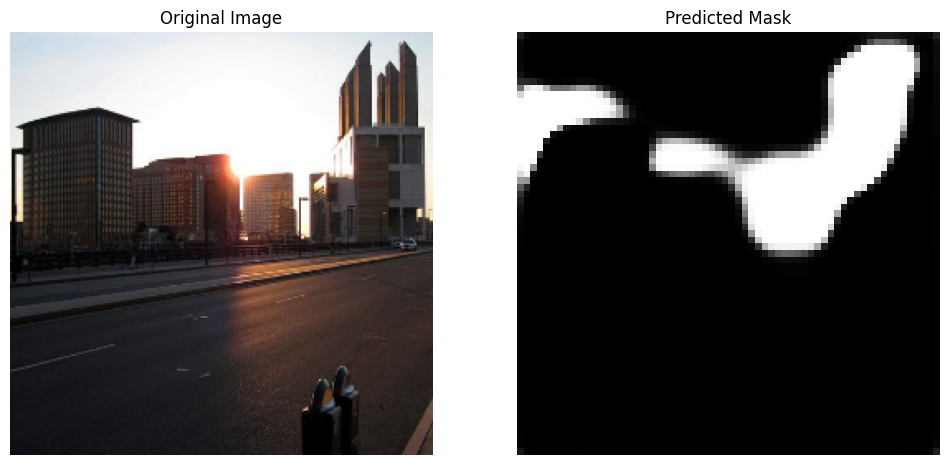

torch.Size([1, 3, 256, 256])


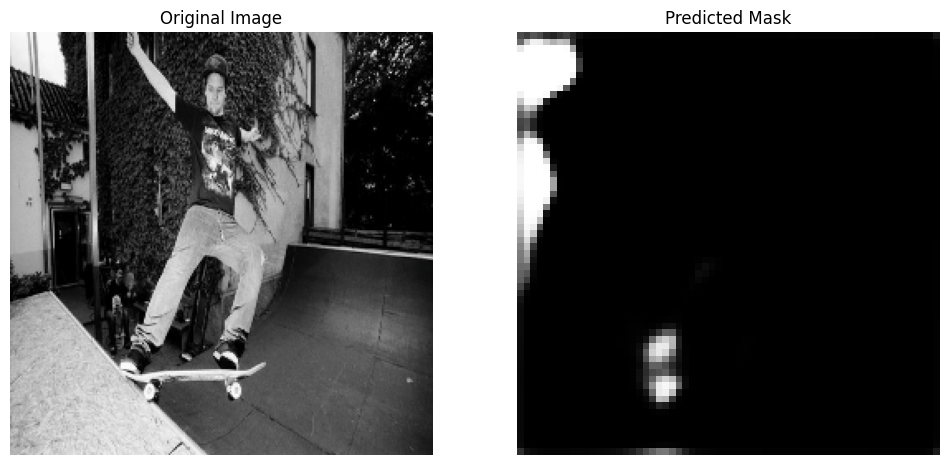

torch.Size([1, 3, 256, 256])


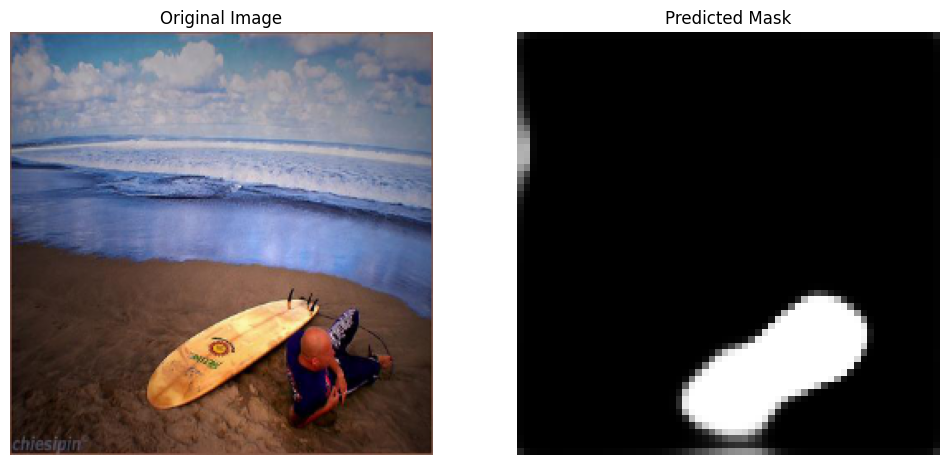

torch.Size([1, 3, 256, 256])


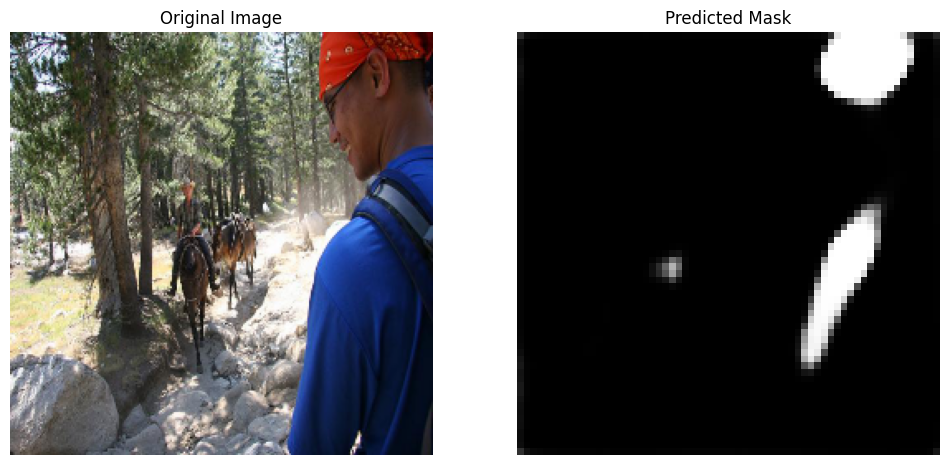

torch.Size([1, 3, 256, 256])


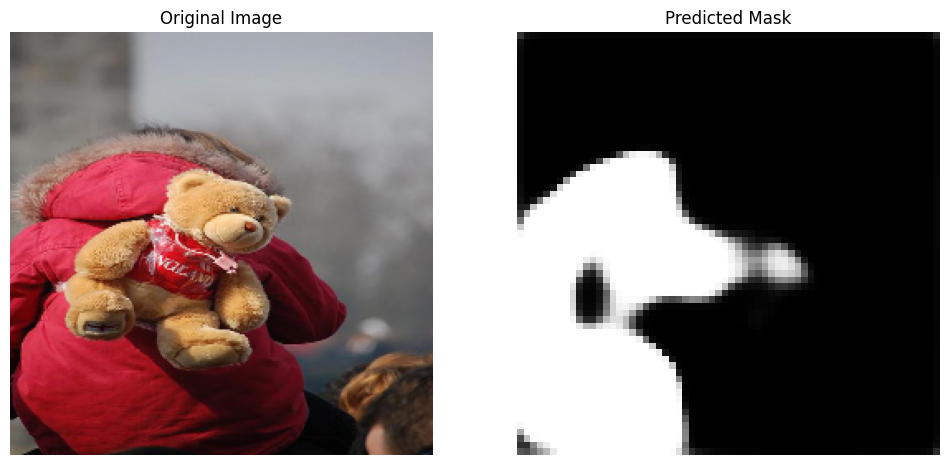

torch.Size([1, 3, 256, 256])


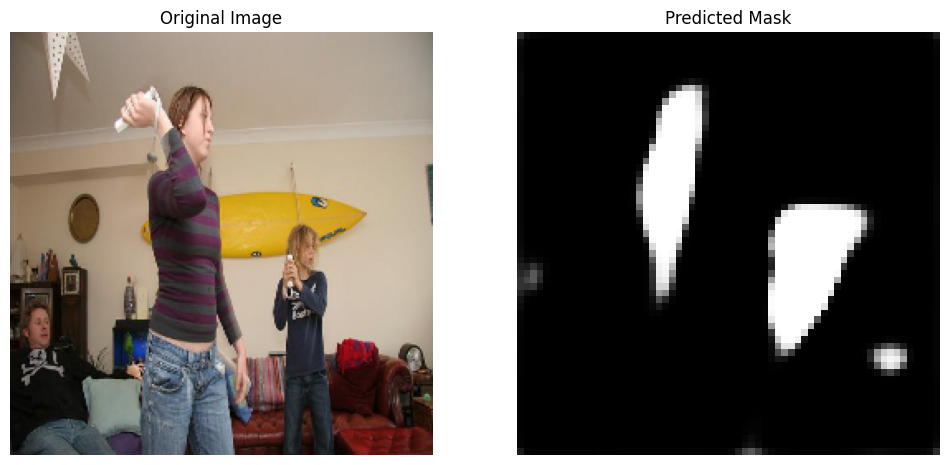

In [262]:
# subset_size = 4
# indices = np.random.choice(1700, subset_size, replace=False)
# subset = Subset(dataset, indices)

# # Create a DataLoader for the subset
# subset_dataloader = DataLoader(subset, batch_size=1, shuffle=False)  # Batch size is 1 for individual processing

# Setup for evaluation
model.eval()
with torch.no_grad():
    for inputs, mask in subset_dataloader:
        plt.figure(figsize=(12, 6))
        plt.subplot(1, 2, 1)
        # Ensure the input tensor is in the right shape (C, H, W) and range (0, 1)
        inputs = unnormalize(inputs)
        print(inputs.shape)
        image = transforms.ToPILImage()(inputs.squeeze(0))
        plt.imshow(image)
        plt.title('Original Image')
        plt.axis('off')

        # only sigmoiding here? 
        pred = torch.sigmoid(model(inputs.to(device)))
        pred_mask = pred.squeeze().cpu().numpy() # 1, H, W
        
        # Display the predicted mask
        plt.subplot(1, 2, 2)  # Predicted mask on the right
        plt.imshow(pred_mask, cmap='gray')
        
        # show the mask
#         plt.imshow(mask.cpu().squeeze(0).permute(1,2,0).numpy(), cmap='gray')

        plt.title('Predicted Mask')
        plt.axis('off')
        
        plt.show()

In [218]:
np.unique(pred_mask)

array([1.], dtype=float32)